In [1]:
import numpy as np
import nlpaug.augmenter.word as naw
from tqdm import tqdm
from sklearn.utils import shuffle
import pandas as pd

/home/jwkim/anaconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
def augment_data_and_upsample(data_path, minority_class, pr, aug_const, ratio_insert):
    aug_insert = naw.ContextualWordEmbsAug(
        model_path='roberta-base', action="insert", device='cuda', aug_p=pr)
    aug_sub = naw.ContextualWordEmbsAug(
        model_path='roberta-base', action="substitute", device='cuda', aug_p=pr)

    # Read in the CSV file
    df = pd.read_table(data_path)
    
    new_texts = []
    # Selecting the minority class samples
    df_minority = df[df.label == minority_class].reset_index(drop=True)
    df_majority = df[df.label == 0].reset_index(drop=True)
    print(len(df))
    n_minority = len(df_minority)
    n_major = len(df_majority)
    assert n_minority < n_major
    assert n_minority + n_major == len(df)

    # Calculating the number of samples to be generated
    n_samples_major = int(n_major * aug_const)
    n_samples_minor = (n_samples_major + n_major) - n_minority
    print("minority, majority", n_minority, n_major)
    print("n samples minor / major", n_samples_minor, n_samples_major)
    print("Total samples after aug ", n_minority + n_samples_minor + n_major + n_samples_major)
    
    # Augmenting the minority class samples
    n_insert= int(n_samples_minor * ratio_insert)
    n_sub = n_samples_minor - n_insert

    for i in tqdm(np.random.randint(0, n_minority, n_insert)):
        text = df_minority.iloc[i]['text']
        augmented_text = aug_insert.augment(text)[0]
        assert type(augmented_text) == str
        new_texts.append(augmented_text)
    for i in tqdm(np.random.randint(0, n_minority, n_sub)):
        text = df_minority.iloc[i]['text']
        augmented_text = aug_sub.augment(text)[0]
        assert type(augmented_text) == str
        new_texts.append(augmented_text)

    new_df = pd.DataFrame({'text': new_texts, 'label': minority_class})
    df = shuffle(df.append(new_df).reset_index(drop=True))
    
    # Augmenting the majority class samples
    n_insert= n_samples_major // 2
    n_sub = n_samples_major - n_insert

    new_texts_major = []

    for i in tqdm(np.random.randint(0, n_major, n_insert)):
        text = df_majority.iloc[i]['text']
        augmented_text = aug_insert.augment(text)[0]
        assert type(augmented_text) == str
        new_texts_major.append(augmented_text)
    
    for i in tqdm(np.random.randint(0, n_major, n_sub)):
        text = df_majority.iloc[i]['text']
        augmented_text = aug_sub.augment(text)[0]
        assert type(augmented_text) == str
        new_texts_major.append(augmented_text)

    majority_class = 0

    new_df = pd.DataFrame({'text': new_texts_major, 'label': 0})
    df = shuffle(df.append(new_df).reset_index(drop=True))

    df = df[['text', 'label']]
    
    return df

In [44]:
df_aug2 = augment_data_and_upsample("../data/train.tsv", 1, 0.2, 0.2, 0.5)

6700
minority, majority 626 6074
n samples minor / major 6662 1214
Total samples after aug  14576


100%|██████████| 3331/3331 [03:49<00:00, 14.53it/s]
/tmp/ipykernel_25976/440785978.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = shuffle(df.append(new_df).reset_index(drop=True))
100%|██████████| 607/607 [00:38<00:00, 15.65it/s]
/tmp/ipykernel_25976/440785978.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = shuffle(df.append(new_df).reset_index(drop=True))


In [45]:
df_aug2.head()

,text,label
11084,From his tall story and real-life encounters w...,1
317,"As a result, millions of Syrians as well widel...",1
7267,Akka was the symbol of simplicity often dresse...,1
3229,A nationally vulnerable Toroa Northern Royal A...,0
9381,In a any nation where people with disabilities...,1


In [48]:
# Store the dataset into a file.
import csv
df_aug.to_csv("../data/train_aug_roberta.csv", sep=',', index=False, quoting=csv.QUOTE_NONE, escapechar='\\')

0    0.656842
1    0.343158
Name: label, dtype: float64


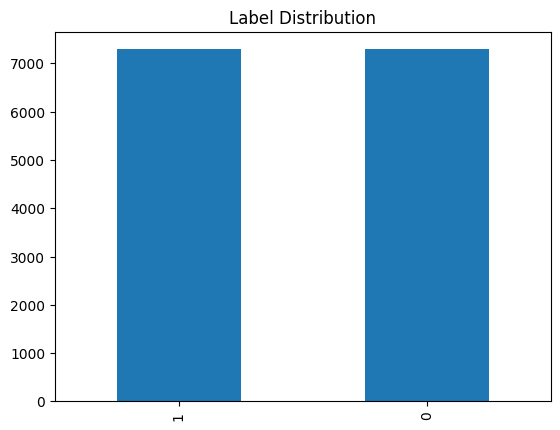

In [49]:
import matplotlib.pyplot as plt
df_aug2.label.value_counts().plot(kind='bar', title='Label Distribution')
print(df_aug.label.value_counts(normalize=True))

In [66]:
# Augmentation using Word2Vec

import os 
os.environ["MODEL_DIR"] + '../model'

def augment_data_and_upsample_word2vec(data_path, minority_class, pr, aug_const, ratio_insert):
    # aug_insert = naw.WordEmbsAug(
    #     model_type='word2vec', action="insert", aug_p=pr, model_path='GoogleNews-vectors-negative300.bin')
    # aug_sub = naw.WordEmbsAug(
    #     model_type='word2vec', action="substitute", aug_p=pr, model_path='GoogleNews-vectors-negative300.bin')
    aug_insert = naw.TfIdfAug(
        model_path=os.environ.get("MODEL_DIR"),
        action="insert")
    aug_sub = naw.TfIdfAug(
        model_path=os.environ.get("MODEL_DIR"),
        action="substitute")

    # Read in the CSV file
    df = pd.read_table(data_path)
    
    new_texts = []
    # Selecting the minority class samples
    df_minority = df[df.label == minority_class].reset_index(drop=True)
    df_majority = df[df.label == 0].reset_index(drop=True)
    print(len(df))
    n_minority = len(df_minority)
    n_major = len(df_majority)
    assert n_minority < n_major
    assert n_minority + n_major == len(df)

    # Calculating the number of samples to be generated
    n_samples_major = int(n_major * aug_const)
    n_samples_minor = (n_samples_major + n_major) - n_minority
    print("minority, majority", n_minority, n_major)
    print("n samples minor / major", n_samples_minor, n_samples_major)
    print("Total samples after aug ", n_minority + n_samples_minor + n_major + n_samples_major)
    
    # Augmenting the minority class samples
    n_insert= int(n_samples_minor * ratio_insert)
    n_sub = n_samples_minor - n_insert

    for i in tqdm(np.random.randint(0, n_minority, n_insert)):
        text = df_minority.iloc[i]['text']
        augmented_text = aug_insert.augment(text)[0]
        assert type(augmented_text) == str
        new_texts.append(augmented_text)
    for i in tqdm(np.random.randint(0, n_minority, n_sub)):
        text = df_minority.iloc[i]['text']
        augmented_text = aug_sub.augment(text)[0]
        assert type(augmented_text) == str
        new_texts.append(augmented_text)

    new_df = pd.DataFrame({'text': new_texts, 'label': minority_class})
    df = shuffle(df.append(new_df).reset_index(drop=True))
    
    # Augmenting the majority class samples
    n_insert= n_samples_major // 2
    n_sub = n_samples_major - n_insert

    new_texts_major = []

    for i in tqdm(np.random.randint(0, n_major, n_insert)):
        text = df_majority.iloc[i]['text']
        augmented_text = aug_insert.augment(text)[0]
        assert type(augmented_text) == str
        new_texts_major.append(augmented_text)
    
    for i in tqdm(np.random.randint(0, n_major, n_sub)):
        text = df_majority.iloc[i]['text']
        augmented_text = aug_sub.augment(text)[0]
        assert type(augmented_text) == str
        new_texts_major.append(augmented_text)

    majority_class = 0

    new_df = pd.DataFrame({'text': new_texts_major, 'label': 0})
    df = shuffle(df.append(new_df).reset_index(drop=True))

    df = df[['text', 'label']]
    
    return df

KeyError: 'MODEL_DIR'

In [67]:
df_aug_word2vec = augment_data_and_upsample_word2vec("../data/train.tsv", 1, 0.2, 0.2, 0.5)

FileNotFoundError: [Errno 2] No such file or directory: './tfidfaug_w2idf.txt'